In [1]:
pip install missingno

In [2]:
pip install xgboost 

Note: you may need to restart the kernel to use updated packages.


## 1. 패키지 불러오기

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency
from scipy import stats
%matplotlib inline

#학습/테스트 데이터 분리
from sklearn.model_selection import train_test_split

#분류 알고리즘
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier

#모델 평가지표
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, recall_score,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, KFold

## 2. 데이터 불러오기

In [4]:
titanic_df=pd.read_csv('~/data/titanic_df.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 3. EDA 및 데이터 전처리
<전처리 과정>
- Null 값 처리
- 분석에 필요없는 칼럼 제거
- EDA: 변수별 분포와 Survived 비율 확인
- Ticket 변수 의미 확인 (교차분석)
- 레이블 인코딩

### 3-1. Null값 처리

#### 결측치 확인

<AxesSubplot:>

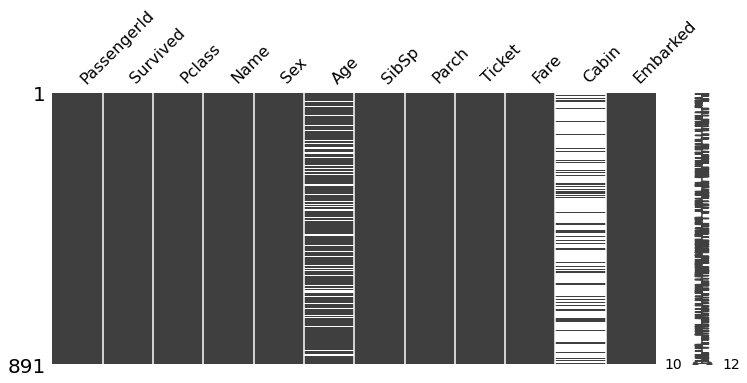

In [7]:
msno.matrix(titanic_df,figsize=(12,5))

In [8]:
#전체 데이터에서 결측치의 비율 확인
titanic_df.isnull().sum() / len(titanic_df)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

- Cabin: 77%가 결측치이므로 Cabin 칼럼 전체를 제거한다.
- Embarked: 결측치가 아주 적으며, 카테고리형이므로 최빈값으로 대체한다.
- Age: 20%가 결측치, 데이터 수가 적으므로 제거하지 않고 대체한다.

#### 결측치 처리: Cabin, Embarked, Age

In [5]:
#Cabin과 Embarked의 결측치 처리
titanic_df.drop(['Cabin'],axis=1,inplace=True)
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0],inplace=True)

Age의 결측치 처리
- Name의 호칭: 성별과 나이를 어느정도 알 수 있음
- Name칼럼을 이용해 Age 결측치 처리

In [6]:
#Name에서 호칭만 분리하여 Title 변수 생성
titanic_df['Title']=""

for i in titanic_df:
    titanic_df['Title']=titanic_df['Name'].str.extract('([A-Za-z]+)\.')

In [11]:
pd.crosstab(titanic_df['Title'],titanic_df['Sex']).T.style.background_gradient()

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- Master, Miss, Mr, Mrs가 대부분이고 나머지 호칭들은 적음

In [7]:
#유사한 호칭을 카테고리로 묶음
for i in range(len(titanic_df['Title'])):
    titanic_df['Title'] =  titanic_df['Title'].replace(['Lady', 'Ms','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Others')

    titanic_df['Title'] =  titanic_df['Title'].replace('Mlle', 'Miss') #마드모아젤
    titanic_df['Title']=  titanic_df['Title'].replace('Countess', 'Mrs') #백작부인
    titanic_df['Title'] =  titanic_df['Title'].replace('Mme', 'Mrs') #마담

In [13]:
titanic_df['Title'].value_counts()

Mr        517
Miss      184
Mrs       127
Master     40
Others     23
Name: Title, dtype: int64

In [14]:
#호칭별 평균나이
titanic_df.groupby('Title')['Age'].mean().round(1)

Title
Master     4.6
Miss      21.8
Mr        32.4
Mrs       35.8
Others    45.3
Name: Age, dtype: float64

- 호칭별로 나이에서 유의미한 차이가 존재한다.
- 같은 성별인데도 여자는 14살, 남자는 28살 차이가 난다.

In [8]:
#호칭별 평균 나이로 Age의 Null값 대체
titanic_df["Age"].fillna(titanic_df.groupby(['Title'])["Age"].transform('mean').round(2) , inplace = True)

In [9]:
#결측치 없어졌는지 확인
titanic_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

### 3-2. 필요없는 칼럼 제거

In [10]:
titanic_df.drop(['PassengerId','Name'],axis=1,inplace=True)

### 3-3. EDA

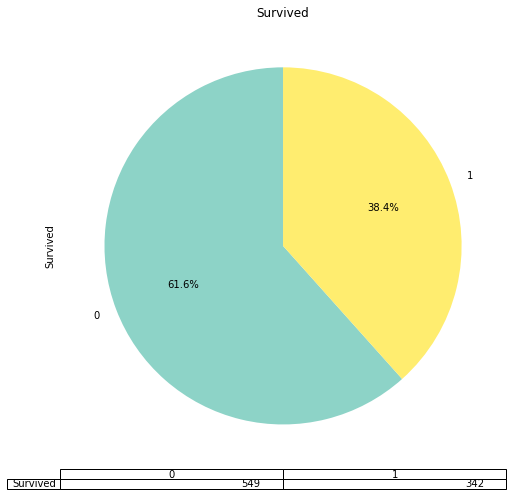

In [18]:
#Target 변수: Survived
plt.figure(figsize=(8,10))
titanic_df['Survived'].value_counts().plot.pie(autopct='%.1f%%',cmap='Set3',startangle=90,table=True)
plt.title('Survived')
plt.show()

- y값이 한 쪽에 심하게 치우치지 않았다.
- 사망자가 61.6%로 생존자보다 더 많다.

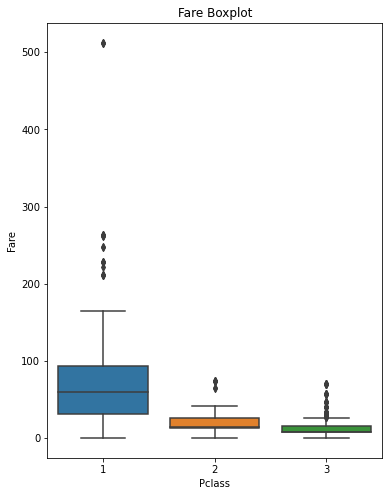

In [19]:
#Fare
plt.figure(figsize=(6,8))
sns.boxplot(x='Pclass',y='Fare',data=titanic_df)
plt.title('Fare Boxplot')
plt.show()

- Pclass가 작을수록 Fare가 큼: 보통의 경우처럼 Pclass 1이 가장 높은 등급, Pclass 3이 가장 낮은 등급인 것을 확인함
- Pclass1에서 500달러 이상의 Outlier가 발견됨: 데이터 수가 많지 않고 500달러 이상을 주고 살 수도 있다고 생각하여 제거X

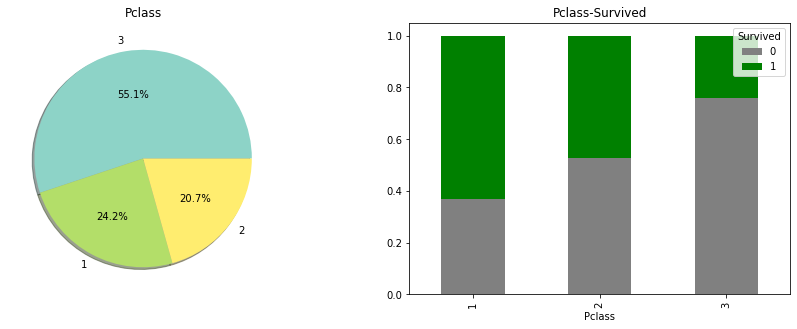

In [20]:
#Pclass
f,ax = plt.subplots(1,2,figsize=(15,5))

titanic_df['Pclass'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,cmap='Set3')
ax[0].set_title('Pclass')
ax[0].set_ylabel('')

titanic_df.groupby('Pclass')['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True, color=['grey', 'green'], ax=ax[1])
ax[1].set_title('Pclass-Survived')
plt.show()

- Pclass3에 탑승자가 가장 많다.
- 클래스 별로 인원이 다름: 단순 count로 Survived로 확인하는 것은 비효율적
- 각 클래스의 총 인원을 100으로 보았을 때, 생존자와 사망자의 비율
- "객실 등급이 낮을수록 사망자의 비율이 높다."

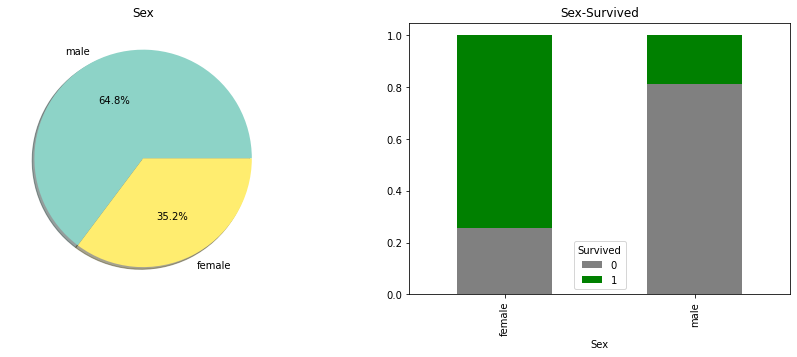

In [21]:
#Sex
f,ax = plt.subplots(1,2,figsize=(15,5))

titanic_df['Sex'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,cmap='Set3')
ax[0].set_title('Sex')
ax[0].set_ylabel('')

titanic_df.groupby('Sex')['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True, color=['grey', 'green'], ax=ax[1])
ax[1].set_title('Sex-Survived')
plt.show()

- 남자 탑승자가 더 많다.
- "여자는 생존자가 과반수, 남자는 사망자가 과반수"

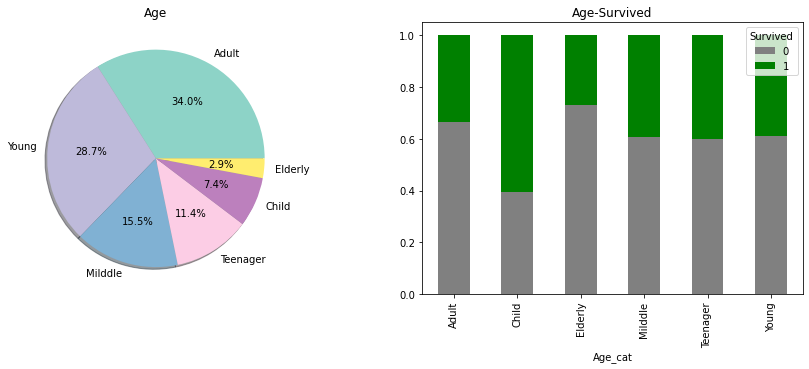

In [22]:
#Age
def get_category(age):
    cat = ''
    if age <= 9: cat = 'Child'
    elif age <= 19: cat = 'Teenager'
    elif age <= 29: cat = 'Young'
    elif age <= 39: cat = 'Adult'
    elif age <= 59: cat ='Milddle'
    else : cat = 'Elderly'
    
    return cat

titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
age_names = ['Child','Teenager','Young','Adult','Middle','Elderly']

f,ax = plt.subplots(1,2,figsize=(15,5))

titanic_df['Age_cat'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,cmap='Set3')
ax[0].set_title('Age')
ax[0].set_ylabel('')

titanic_df.groupby('Age_cat')['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True, color=['grey', 'green'], ax=ax[1])
ax[1].set_title('Age-Survived')
plt.show()

titanic_df.drop(['Age_cat'],axis=1,inplace=True)

- Age 연속형: 보기 쉽게 카테고리로 묶음
- 20, 30대 탑승자(Young, Adult)가 가장 많다.
- Child의 생존율이 가장 높다.
- 나이가 어릴수록 생존율이 높다. (but 차이 크지 않음)

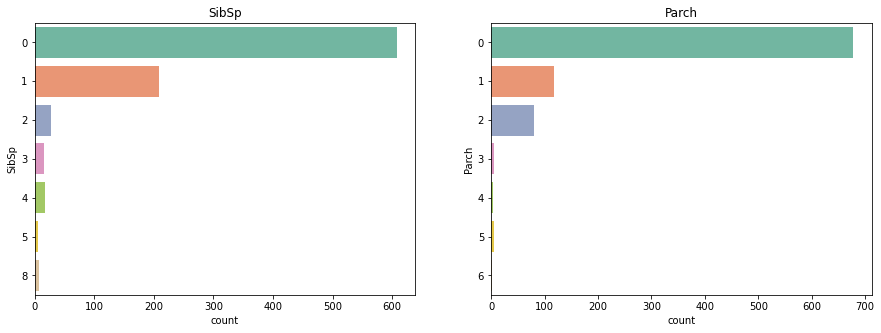

In [23]:
#SibSp, Parch
f,ax = plt.subplots(1,2,figsize=(15,5))

sns.countplot(y='SibSp',data=titanic_df,ax=ax[0],palette='Set2')
ax[0].set_title('SibSp')

sns.countplot(y='Parch',data=titanic_df,ax=ax[1],palette='Set2')
ax[1].set_title('Parch')
plt.show()

- SibSp: 동반한 형제자매/배우자의 수
- Parch: 동반한 부모/자녀의 수
- 두 변수 모두 동반한 사람이 없는 경우가 가장 많다.
- 두 변수 모두 동반한 사람이 3명 이상인 경우는 매우 적다.

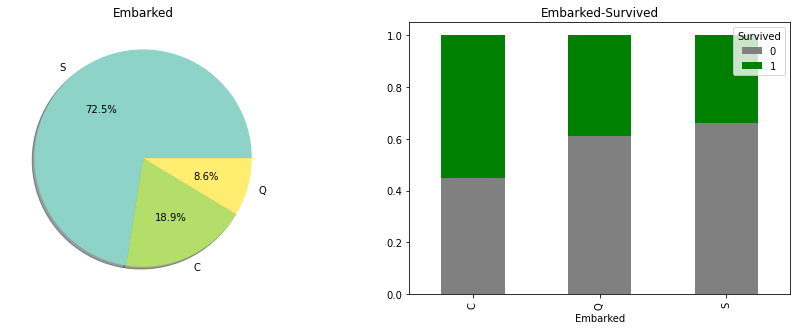

In [24]:
#Embarked
f,ax = plt.subplots(1,2,figsize=(15,5))

titanic_df['Embarked'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,cmap='Set3')
ax[0].set_title('Embarked')
ax[0].set_ylabel('')

titanic_df.groupby('Embarked')['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True, color=['grey', 'green'], ax=ax[1])
ax[1].set_title('Embarked-Survived')
plt.show()

- S(사우샘프턴)에서 탑승한 사람이 가장 많다.
- C(셰르부르) 탑승객의 생존율이 가장 높다.

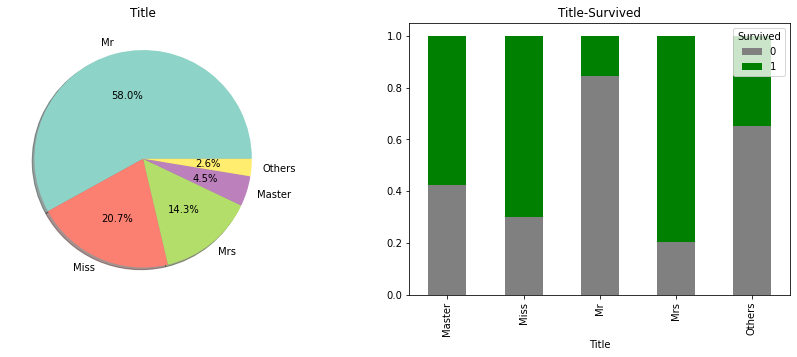

In [25]:
#Title
f,ax = plt.subplots(1,2,figsize=(15,5))

titanic_df['Title'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,cmap='Set3')
ax[0].set_title('Title')
ax[0].set_ylabel('')

titanic_df.groupby('Title')['Survived'].value_counts(normalize=True).unstack('Survived').plot.bar(stacked=True, color=['grey', 'green'], ax=ax[1])
ax[1].set_title('Title-Survived')
plt.show()

- 기혼 남성 승객이 가장 많다.
- But Mr의 사망율이 가장 높다. 
- Mrs와 Miss/ Master는 상대적으로 생존율이 높다: 여성/어린이라서 우선적으로 구조되었을 것

In [26]:
#Ticket
titanic_df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

- 일련번호 형식(코드같은 느낌): count해서 같은 값이 있는지 확인
- 같은 코드=같은 티켓
- 같은 코드의 티켓을 소지한 승객들은 동반했다고 해석

### 3-4. Ticket 변수의 의미 확인하기
- 'Ticket으로 동반탑승한 사람의 수를 확인할 수 있다' 해석
- SibSp와 Parch가 동반한 가족을 나타내는 변수이므로 Ticket과 두 변수의 관련성이 높다면 위 해석이 맞는 것으로 간주  : Ticket 제거

#### 교차분석
상관분석: 두 변수 간의 선형관계의 방향과 강도를 확인한다. = 선형성을 기본 가정으로 함

but 범주형 변수는 선형관계로 나타낼 수 없다.

두 범주형 변수 간의 관련성을 확인할 때 사용하는 방법이 교차분석(카이제곱 검정)이다.

- 귀무가설1: SibSp와 Ticket은 독립사건이다. (관련성X)
- 대립가설1: SibSp와 Ticket은 종속사건이다. (관련성o)



- 귀무가설2: Parch와 Ticket은 독립사건이다. (관련성X)
- 대립가설2: Parch와 Ticket은 종속사건이다. (관련성o)

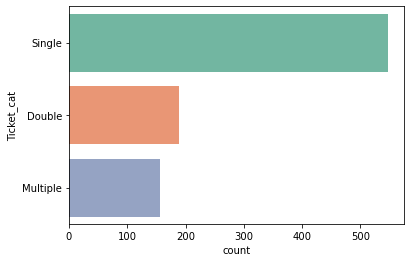

In [13]:
#같은 코드를 가진 수대로 Ticket 카테고리화
#1개: single, 2개: Double, 3개 이상: Multiple

titanic_df['Ticket_cat']=""

for i in range(len(titanic_df['Ticket'])):
    if titanic_df['Ticket'][i] in (titanic_df['Ticket'].value_counts()[titanic_df['Ticket'].value_counts()==1]).index:
        titanic_df['Ticket_cat'][i]='Single'
    elif titanic_df['Ticket'][i] in (titanic_df['Ticket'].value_counts()[titanic_df['Ticket'].value_counts()==2]).index:
        titanic_df['Ticket_cat'][i]='Double'
    else:
        titanic_df['Ticket_cat'][i]='Multiple'

sns.countplot(y='Ticket_cat',data=titanic_df,palette='Set2')
plt.show()

- 동반 탑승객이 없이 혼자 탑승한 승객이 많다.

In [14]:
#교차분석을 위해 SibSp, Parch도 카테고리화
titanic_df['SibSp_cat']=""

for i in range(len(titanic_df['SibSp'])):
    if titanic_df['SibSp'][i]==0:
        titanic_df['SibSp_cat'][i]='Single'
    elif titanic_df['SibSp'][i] ==1:
        titanic_df['SibSp_cat'][i]='Double'
    else:
        titanic_df['SibSp_cat'][i]='Multiple'
        
titanic_df['Parch_cat']=""

for i in range(len(titanic_df['Parch'])):
    if titanic_df['Parch'][i]==0:
        titanic_df['Parch_cat'][i]='Single'
    elif titanic_df['Parch'][i] ==1:
        titanic_df['Parch_cat'][i]='Double'
    else:
        titanic_df['Parch_cat'][i]='Multiple'

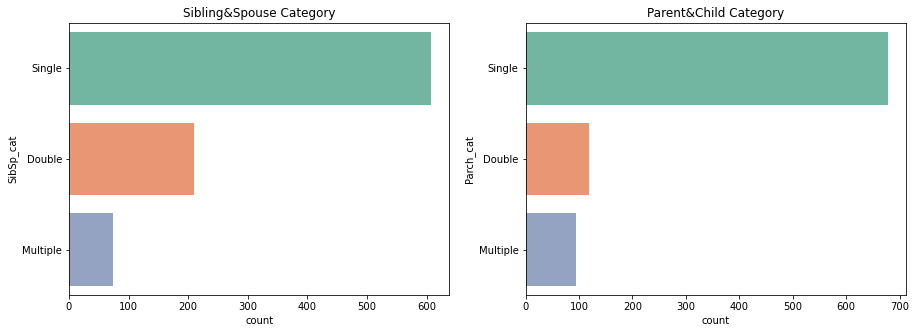

In [29]:
f,ax= plt.subplots(1,2,figsize=(15,5))

group_names = ['Single','Double','Multiple']

sns.countplot(y='SibSp_cat',data=titanic_df,ax=ax[0],palette='Set2',order=group_names)
ax[0].set_title('Sibling&Spouse Category')


sns.countplot(y='Parch_cat',data=titanic_df,ax=ax[1],palette='Set2')
ax[1].set_title('Parent&Child Category')

plt.show()

In [15]:
#Ticket과 SibSp, Parch의 상호연관성 확인: 교차분석
#Ticket과 SibSp 교차표
titanic_df['Ticket_cat'] = titanic_df['Ticket_cat'].astype('category')
titanic_df['Ticket_cat'] =titanic_df['Ticket_cat'].cat.set_categories(['Single', 'Double', 'Multiple'], ordered=True)

titanic_df['SibSp_cat'] = titanic_df['SibSp_cat'].astype('category')
titanic_df['SibSp_cat'] =titanic_df['SibSp_cat'].cat.set_categories(['Single', 'Double', 'Multiple'], ordered=True)

s_cross=pd.crosstab(titanic_df['Ticket_cat'],titanic_df['SibSp_cat'])

#Ticket과 Parch 교차표
titanic_df['Parch_cat'] = titanic_df['Parch_cat'].astype('category')
titanic_df['Parch_cat'] =titanic_df['Parch_cat'].cat.set_categories(['Single', 'Double', 'Multiple'], ordered=True)

p_cross=pd.crosstab(titanic_df['Ticket_cat'],titanic_df['Parch_cat'])

In [16]:
#교차표가 뭔지
s_cross.T.style

Ticket_cat,Single,Double,Multiple
SibSp_cat,,,
Single,482,71,55
Double,57,103,49
Multiple,8,14,52


In [32]:
#Ticket&SibSp 교차분석
result=chi2_contingency(observed=s_cross, correction=False)
print("1. 카이제곱 통계량:", result[0])
print("2. p-value:", result[1])

1. 카이제곱 통계량: 353.3017009610004
2. p-value: 3.3968604361848484e-75


In [33]:
#Ticket&Parch 교차분석
result=chi2_contingency(observed=p_cross, correction=False)
print("1. 카이제곱 통계량:", result[0])
print("2. p-value:", result[1])

1. 카이제곱 통계량: 345.5820567396321
2. p-value: 1.5770200309296128e-73


- 둘 다 P-value가 0.00으로 통계적으로 유의미하다.
- 귀무가설 기각: Ticket과 SibSp, Parch의 관련성이 있다.
- SibSp와 Parch가 Ticket보다 더 자세한 데이터를 담고 있으므로 Ticket 칼럼을 제거한다.

In [17]:
#TIcket과 교차분석을 위해 생성한 칼럼 제거
titanic_df.drop(['Ticket','Ticket_cat','SibSp_cat','Parch_cat'],axis=1,inplace=True)

### 3-5. 레이블 인코딩
- Sex, Title, Embarked

In [18]:
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Sex','Title', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,2,2
1,1,1,0,38.0,1,0,71.2833,0,3
2,1,3,0,26.0,0,0,7.9250,2,1
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,2,2


## 4. XGBoost

### 4-1. 모든 변수로 학습: x_model1

데이터 분리 및 모델 생성/학습

In [19]:
#데이터 분리
y=titanic_df['Survived']
X=titanic_df.drop(['Survived'],axis=1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=156)

#모델 생성 및 학습
evals=[(X_test,y_test)] #조기 중단을 위한 데이터셋 준비
x_model1=XGBClassifier(n_esimators=400,learning_rate=0.1,max_depth=3,random_state=156)
x_model1.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)

[17:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_esimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64758
[1]	validation_0-logloss:0.61120
[2]	validation_0-logloss:0.57935
[3]	validation_0-logloss:0.55274
[4]	validation_0-logloss:0.52998
[5]	validation_0-logloss:0.51097
[6]	validation_0-logloss:0.49484
[7]	validation_0-logloss:0.48121
[8]	validation_0-logloss:0.47012
[9]	validation_0-logloss:0.46012
[10]	validation_0-logloss:0.45245
[11]	validation_0-logloss:0.44581
[12]	validation_0-logloss:0.44048
[13]	validation_0-logloss:0.43551
[14]	validation_0-logloss:0.42998
[15]	validation_0-logloss:0.42681
[16]	validation_0-logloss:0.42282
[17]	validat

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_esimators=400,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=156, reg_alpha=0, ...)

모델 검정

In [22]:
#성능평가 지표를 한꺼번에 출력하는 함수 정의
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [20]:
#X_test의 결과값 예측
x_pred1=x_model1.predict(X_test)
x_pred_p1=x_model1.predict_proba(X_test)[:,1]

In [23]:
#실제값(y_test)과 예측값(pred)을 비교하여 모델의 성능을 평가한다.
get_clf_eval(y_test,x_pred1)

오차 행렬
[[95 12]
 [22 50]]
정확도: 0.8101, 정밀도: 0.8065, 재현율: 0.6944,    F1: 0.7463, AUC:0.7911


피처 중요도 확인

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

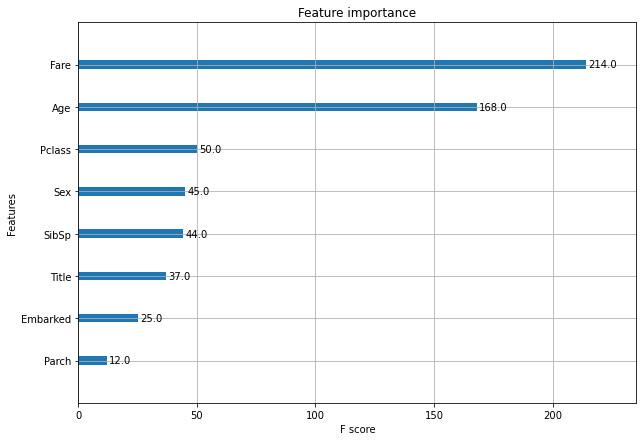

In [25]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots(figsize=(10,7))
plot_importance(x_model1,ax=ax)

- Parch의 중요도가 다른 변수들에 비해 크게 떨어짐
- Parch를 제외한 변수들로 다시 학습

### 4-2. Parch 제외: x_model2

데이터 분리 및 모델 생성/학습

In [27]:
#데이터 분리 (y는 이전 모델과 같음)
X_p=titanic_df.drop(['Survived','Parch'],axis=1)
X_train_p,X_test_p,y_train_p,y_test_p=train_test_split(X_p,y,test_size=0.2,random_state=156)

#모델 생성 및 학습
evals_p=[(X_test_p,y_test_p)]
x_model2=XGBClassifier(n_esimators=400,learning_rate=0.1,max_depth=3,random_state=156)
x_model2.fit(X_train_p,y_train_p,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals_p,verbose=True)

[17:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_esimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64758
[1]	validation_0-logloss:0.61120
[2]	validation_0-logloss:0.57935
[3]	validation_0-logloss:0.55274
[4]	validation_0-logloss:0.52998
[5]	validation_0-logloss:0.51097
[6]	validation_0-logloss:0.49484
[7]	validation_0-logloss:0.48121
[8]	validation_0-logloss:0.47012
[9]	validation_0-logloss:0.46012
[10]	validation_0-logloss:0.45245
[11]	validation_0-logloss:0.44581
[12]	validation_0-logloss:0.44048
[13]	validation_0-logloss:0.43551
[14]	validation_0-logloss:0.42998
[15]	validation_0-logloss:0.42681
[16]	validation_0-logloss:0.42282
[17]	validat

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_esimators=400,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=156, reg_alpha=0, ...)

모델 검정

In [29]:
#X_test_p의 결과값 예측
x_pred2=x_model2.predict(X_test_p)
x_pred_p2=x_model2.predict_proba(X_test_p)[:,1]

In [37]:
#실제값(y_test_p)과 예측값(x_pred2)을 비교하여 모델 성능 평가
get_clf_eval(y_test_p,x_pred2)

오차 행렬
[[96 11]
 [19 53]]
정확도: 0.8324, 정밀도: 0.8281, 재현율: 0.7361,    F1: 0.7794, AUC:0.8167


- Parch 칼럼 제외 후 학습한 모델의 성능이 더 높다.

### 4-3. FamilySize 칼럼 생성 후 학습: x_model3

FamilySize 칼럼 생성

In [38]:
#SibSp와 Parch로 가족 수를 나타내는 FamilySize 생성, 자기자신을 포함하기 위해 +1
titanic_df['FamilySize'] =titanic_df['SibSp'] + titanic_df['Parch'] + 1 
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,0,3,1,22.0,1,0,7.2500,2,2,2
1,1,1,0,38.0,1,0,71.2833,0,3,2
2,1,3,0,26.0,0,0,7.9250,2,1,1
3,1,1,0,35.0,1,0,53.1000,2,3,2
4,0,3,1,35.0,0,0,8.0500,2,2,1


데이터 분리 및 모델 생성/학습

In [39]:
#데이터 분리 (y는 이전 모델과 같음)
X_f=titanic_df.drop(['Survived','SibSp','Parch'],axis=1)
X_train_f,X_test_f,y_train_f,y_test_f=train_test_split(X_f,y,test_size=0.2,random_state=156)

#모델 생성 및 학습
evals_f=[(X_test_f,y_test_f)]
x_model3=XGBClassifier(n_esimators=400,learning_rate=0.1,max_depth=3,random_state=156)
x_model3.fit(X_train_f,y_train_f,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals_f,verbose=True)

[18:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_esimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.64679
[1]	validation_0-logloss:0.60974
[2]	validation_0-logloss:0.57720
[3]	validation_0-logloss:0.54994
[4]	validation_0-logloss:0.52660
[5]	validation_0-logloss:0.50703
[6]	validation_0-logloss:0.48995
[7]	validation_0-logloss:0.47637
[8]	validation_0-logloss:0.46487
[9]	validation_0-logloss:0.45492
[10]	validation_0-logloss:0.44783
[11]	validation_0-logloss:0.44073
[12]	validation_0-logloss:0.43478
[13]	validation_0-logloss:0.42984
[14]	validation_0-logloss:0.42385
[15]	validation_0-logloss:0.41961
[16]	validation_0-logloss:0.41520
[17]	validat

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_esimators=400,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=156, reg_alpha=0, ...)

모델 검정

In [42]:
#X_test_f의 결과값 예측
x_pred3=x_model3.predict(X_test_f)
x_pred_p3=x_model3.predict_proba(X_test_f)[:,1]

In [41]:
#실제값(y_test_f)과 예측값(x_pred3)을 비교하여 모델 성능 평가
get_clf_eval(y_test_f,x_pred3)

오차 행렬
[[95 12]
 [22 50]]
정확도: 0.8101, 정밀도: 0.8065, 재현율: 0.6944,    F1: 0.7463, AUC:0.7911


### 4-4. 최적화: GridSearchCV

<XGBoost 모델 성능 비교>


||모든 변수를 사용한 모델|Parch를 제외한 모델|FamilySize 칼럼을 사용한 모델|
|------|:---:|:---:|:---:|
|**정확도**|0.8101|<span style="color:red">0.8324</span>|0.8101
|**정밀도**|0.8065|<span style="color:red">0.8281</span>|0.8065
|**재현율**| 0.6944|<span style="color:red">0.7361</span>| 0.6944
|**F1 score**|0.7463|<span style="color:red">0.7794</span>|0.7463
|**AUC**|0.7911|<span style="color:red">0.8167</span>|0.7911

- 모든 변수를 사용한 모델과 FamilySize 칼럼을 사용한 모델의 성능이 같다.
- 전체 데이터 수가 적어서 다른 모델을 사용하였지만 결과가 같게 나올 수 있다고 추측한다.
- Parch를 제외한 모델(x_model2)의 성능이 가장 높았으므로 이 모델로 최적화를 수행한다.

GridSearch CV로 가장 좋은 하이퍼 파라미터 값을 구한다.

In [43]:
#조정할 파라미터 지정
params_xgb={'max_depth':[5,7],
        'min_child_weight':[1,3],
        'colsample_bytree':[0.5,0.75]}

#그리드서치
grid_xgb=GridSearchCV(x_model2,param_grid=params_xgb,cv=3) #교차검증 3번
grid_xgb.fit(X_train_p,y_train_p,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals_p,verbose=True)

[18:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_esimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.67050
[1]	validation_0-logloss:0.63936
[2]	validation_0-logloss:0.60419
[3]	validation_0-logloss:0.59234
[4]	validation_0-logloss:0.57936
[5]	validation_0-logloss:0.55565
[6]	validation_0-logloss:0.55014
[7]	validation_0-logloss:0.52808
[8]	validation_0-logloss:0.50995
[9]	validation_0-logloss:0.49598
[10]	validation_0-logloss:0.48441
[11]	validation_0-logloss:0.47700
[12]	validation_0-logloss:0.46457
[13]	validation_0-logloss:0.46180
[14]	validation_0-logloss:0.45966
[15]	validation_0-logloss:0.45407
[16]	validation_0-logloss:0.44941
[17]	validat

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=3, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()', n_esimators=400,
          

#1. best_estimator_를 사용해 best parameter로 바로 학습/예측하는 경우
- 자동적으로 모든 하이퍼 파라미터를 조정한다.

In [77]:
#best parameter로 학습된 모델로 X_test_p의 결과값 예측
grid_x_pred=grid_xgb.best_estimator_.predict(X_test_p)
grid_x_pred_p=grid_xgb.best_estimator_.predict_proba(X_test_p)[:,1]

#모든 하이퍼 파라미터에 대한 best값 확인가능
print('모든 하이퍼 파라미터의 best 값:', grid_xgb.best_estimator_.get_params())

모든 하이퍼 파라미터의 best 값: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 7, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 156, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'n_esimators': 400}


In [60]:
get_clf_eval(y_test_p,grid_x_pred)

오차 행렬
[[97 10]
 [18 54]]
정확도: 0.8436, 정밀도: 0.8438, 재현율: 0.7500,    F1: 0.7941, AUC:0.8283


#2. best parameter를 확인한 후, 해당 값으로 파라미터를 직접 조정하여 학습/예측하는 경우
-  수동으로 하이퍼 파라미터를  best parameter 값으로 조정한다.

In [66]:
#그리드서치cv로 구한 best parameter를 확인한다. (앞서 지정한 하이퍼 파라미터에 대한 best값만 확인 가능)
grid_xgb.best_params_

{'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 1}

In [81]:
#세 가지의 하이퍼 파라미터를 best parameter 값으로 조정하여 학습한다.
x_model2_best=XGBClassifier(colsample_bytree=0.5, max_depth=7, min_child_weight= 1)
x_model2_best.fit(X_train_p,y_train_p,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals_p,verbose=True)

[0]	validation_0-logloss:0.57303
[1]	validation_0-logloss:0.53463
[2]	validation_0-logloss:0.51435
[3]	validation_0-logloss:0.47028
[4]	validation_0-logloss:0.43897
[5]	validation_0-logloss:0.42931
[6]	validation_0-logloss:0.42778
[7]	validation_0-logloss:0.41970
[8]	validation_0-logloss:0.40963
[9]	validation_0-logloss:0.40541
[10]	validation_0-logloss:0.40814
[11]	validation_0-logloss:0.39925
[12]	validation_0-logloss:0.39817
[13]	validation_0-logloss:0.39789
[14]	validation_0-logloss:0.39720
[15]	validation_0-logloss:0.39545
[16]	validation_0-logloss:0.39206
[17]	validation_0-logloss:0.39193
[18]	validation_0-logloss:0.39348
[19]	validation_0-logloss:0.39300
[20]	validation_0-logloss:0.39369
[21]	validation_0-logloss:0.39712
[22]	validation_0-logloss:0.39439
[23]	validation_0-logloss:0.39481
[24]	validation_0-logloss:0.39371
[25]	validation_0-logloss:0.39318
[26]	validation_0-logloss:0.39240
[27]	validation_0-logloss:0.39215
[28]	validation_0-logloss:0.39352
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [82]:
#세 하이퍼 파라미터를 조정하여 학습한 모델로 X_test_p 값을 예측한다.
grid_x_pred2=x_model2_best.predict(X_test_p)
gird_x_pred_p2=x_model2_best.predict_proba(X_test_p)[:,1]

In [83]:
get_clf_eval(y_test_p,grid_x_pred2)

오차 행렬
[[98  9]
 [17 55]]
정확도: 0.8547, 정밀도: 0.8594, 재현율: 0.7639,    F1: 0.8088, AUC:0.8399


<XGBoost: Parch를 제외한 모델의 최적화 전후 성능 비교>

||최적화 전|모든 하이퍼 파라미터 조정|세 가지의 하이퍼 파라미터 조정
|------|:---:|:---:|:---:|
|**정확도**|0.8324|0.8436|<span style="color:red">0.8547</span>
|**정밀도**|0.8281|0.8438|<span style="color:red">0.8594</span>
|**재현율**|0.7361|0.7083|<span style="color:red">0.7639</span>
|**F1 score**|0.7794|0.7500|<span style="color:red">0.8088</span>
|**AUC**|0.8167|0.8283|<span style="color:red">0.8399</span>

- GridSearcgCV 최적화 후 모델의 성능이 다소 개선되었다.
- best_estimator_로 모든 하이퍼 파라미터를 조정했을 때보다 colsample_bytree, max_depth, min_child_weight만을 조정했을 때의 성능이 더 높았다.

## 5. 랜덤 포레스트

### 5-1. 모든 변수로 학습: r_model1

In [69]:
#모델 생성 및 학습
r_model1 = RandomForestClassifier(random_state=156)
r_model1.fit(X_train, y_train)

#모델 검정
r_pred1 = r_model1.predict(X_test)
get_clf_eval(y_test,r_pred1)

오차 행렬
[[95 12]
 [18 54]]
정확도: 0.8324, 정밀도: 0.8182, 재현율: 0.7500,    F1: 0.7826, AUC:0.8189


### 5-2. Parch 제외: r_model2

In [71]:
#모델 생성 및 학습
r_model2 = RandomForestClassifier(random_state=156)
r_model2.fit(X_train_p, y_train_p)

#모델 검정
r_pred2 = r_model2.predict(X_test_p)
get_clf_eval(y_test_p,r_pred2)

오차 행렬
[[98  9]
 [19 53]]
정확도: 0.8436, 정밀도: 0.8548, 재현율: 0.7361,    F1: 0.7910, AUC:0.8260


### 5-3. FamilySize 칼럼 사용: r_model3

In [76]:
#모델 생성 및 학습
r_model3 = RandomForestClassifier(random_state=156)
r_model3.fit(X_train_f, y_train_f)

#모델 검정
r_pred3 = r_model3.predict(X_test_f)
get_clf_eval(y_test_f,r_pred3)

오차 행렬
[[96 11]
 [18 54]]
정확도: 0.8380, 정밀도: 0.8308, 재현율: 0.7500,    F1: 0.7883, AUC:0.8236


### 5-4. 최적화: GridSearchCV

<Random Forest 모델 성능 비교>

||모든 변수를 사용한 모델|Parch를 제외한 모델|FamilySize 칼럼을 사용한 모델|
|------|:---:|:---:|:---:|
|**정확도**|0.8324|<span style="color:red"> 0.8436</span>|0.8380
|**정밀도**|0.8182|<span style="color:red">0.8548</span>|0.8308
|**재현율**|<span style="color:red">0.7500</span>| 0.7361</span>|<span style="color:red">0.7500</span>
|**F1 score**|0.7826|<span style="color:red">0.7910</span>|0.7883
|**AUC**|0.8189|<span style="color:red">0.8260</span>|0.8236

- 재현율을 제외하고 모든 평가지표에서 Parch를 제외한 모델의 성능이 가장 높았다.
- 따라서 Parch를 제외한 모델(r_model2)로 최적화를 수행한다.

In [78]:
#조정할 파라미터 지정
params_rf = {
    'n_estimators':[500],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [20, 25, 30, 35]}

#그리드 서치
grid_rf= GridSearchCV(r_model2 , param_grid=params_rf , cv=3)
grid_rf.fit(X_train_p , y_train_p)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=156),
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [20, 25, 30, 35],
                         'n_estimators': [500]})

In [80]:
grid_rf.best_params_

{'max_depth': 6,
 'min_samples_leaf': 12,
 'min_samples_split': 20,
 'n_estimators': 500}

In [84]:
#최적 파라미터로 학습
r_model2_best= RandomForestClassifier(n_estimators=500, max_depth=6, min_samples_leaf=12,
                                min_samples_split=20, random_state=156)
r_model2_best.fit(X_train_p, y_train_p)

#최적 파라미터로 학습한 모델 검정
grid_r_pred= r_model2_best.predict(X_test_p)
get_clf_eval(y_test_p,grid_r_pred)   

오차 행렬
[[96 11]
 [20 52]]
정확도: 0.8268, 정밀도: 0.8254, 재현율: 0.7222,    F1: 0.7704, AUC:0.8097


<Random Forest: Parch를 제외한 모델의 최적화 전후 성능 비교>

||최적화 전|최적화 후|
|------|:---:|:---:|
|**정확도**|<span style="color:red">0.8436</span>|0.8268
|**정밀도**|<span style="color:red">0.8548</span>|0.8254
|**재현율**|<span style="color:red">0.7361</span>|0.7222
|**F1 score**|<span style="color:red">0.7910</span>|0.7704
|**AUC**|<span style="color:red">0.8260</span>|0.8097

- 최적화 후 모델의 성능이 오히려 떨어졌다.

In [88]:
get_clf_eval(y_test_p,grid_x_pred2)

오차 행렬
[[98  9]
 [17 55]]
정확도: 0.8547, 정밀도: 0.8594, 재현율: 0.7639,    F1: 0.8088, AUC:0.8399


모든 모델 중 "Parch를 제외하고 학습+세 가지 파라미터 조정한 XGBoost 모델"의 성능이 가장 높았다.